In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config = {
    'domain': 'bike',
    'postgres': False,
    'debug': True
}

In [3]:
# Get DB connection string and add to globals
# NOTE: $SNORKELDB must be set before any snorkel imports
import os

default_db_name = 'babble_' + config['domain'] + ('_debug' if config['debug'] else '')
DB_NAME = getattr(config, 'db_name', default_db_name)
if 'postgres' in config and config['postgres']:
    DB_TYPE = 'postgres'
else:
    DB_TYPE = 'sqlite'
    DB_NAME += '.db'
DB_ADDR = "localhost:{0}".format(config['db_port']) if 'db_port' in config else ""
os.environ['SNORKELDB'] = '{0}://{1}/{2}'.format(DB_TYPE, DB_ADDR, DB_NAME)
print("$SNORKELDB = {0}".format(os.environ['SNORKELDB']))

$SNORKELDB = sqlite:///babble_bike_debug.db


In [4]:
from snorkel import SnorkelSession
session = SnorkelSession()

# Resolve config conflicts (nb_config > local_config > global_config)
from snorkel.contrib.babble.pipelines import merge_configs, get_local_pipeline
config = merge_configs(config)

if config['debug']:
    print("NOTE: --debug=True: modifying parameters...")
    config['max_docs'] = 100
    config['gen_model_search_space'] = 2
    config['disc_model_search_space'] = 2
    config['gen-params-default']['epochs'] = 25
    config['disc-params-default']['n_epochs'] = 5

from snorkel.models import candidate_subclass
candidate_class = candidate_subclass(config['candidate_name'], config['candidate_entities'])

pipeline = get_local_pipeline(config['domain'])
pipe = pipeline(session, candidate_class, config)

NOTE: --debug=True: modifying parameters...


In [5]:
pipe.parse()

Clearing existing...
Running UDF...
Running UDF...


In [6]:
pipe.extract()

Extraction was performed during parse stage.
Candidates [Split 0]: 2406
Candidates [Split 1]: 1037


In [7]:
pipe.load_gold()

Reading val CSV!
Num HITs unique: 495
Num HITs total: 997
Unanimous: 311
Majority: 772
Bad: 131
Reading train CSV!
Num HITs unique: 602
Num HITs total: 1806
Unanimous: 1660
Majority: 883
Bad: 304
AnnotatorLabels created: 906
AnnotatorLabels created: 2102


In [8]:
pipe.collect()

Reading train CSV!
Num HITs unique: 40
Num HITs total: 120
Unanimous: 99
Majority: 63
Bad: 27
Building list of target candidate ids...
Collected 131 unique target candidate ids from 358 explanations.
Gathering desired candidates...
Found 131/131 desired candidates
Linking explanations to candidates...
Linked 358/358 explanations
Calling babbler...
Created grammar with 431 rules
336 parses created from 241 out of 358 explanation(s)
Parsed 336 LFs from 358 explanations.
Filtered to 98 LFs with duplicate semantics filter (238 filtered).
Filtered to 57 LFs with consistency filter (41 filtered).
Clearing existing...
Running UDF...
[========================================] 100%

Filtered to 47 LFs with uniform signatures filter (10 filtered).
Filtered to 33 LFs with duplicate signatures filter (14 filtered).


In [9]:
pipe.label()

Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 0: (2406,33) sparse (nnz = 41059)
Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 1: (1037,33) sparse (nnz = 17416)
                   j  Coverage  Overlaps  Conflicts   TP   FP   FN   TN  \
Explanation11_0    0  0.372228  0.372228   0.372228    0    0   59  278   
Explanation12_0    1  0.487946  0.487946   0.487946    0    0   77  357   
Explanation147_0   2  0.516876  0.516876   0.516876    0    0  101  374   
Explanation16_0    3  0.392478  0.392478   0.392478    0    0   15  353   
Explanation172_0   4  0.591128  0.591128   0.591128  144  355    0    0   
Explanation185_0   5  0.511090  0.511090   0.511090   98  370    0    0   
Explanation197_0   6  0.214079  0.214079   0.214079    0    0    6  195   
Explanation20_0    7  0.816779  0.816779   0.816779    0    0  174  571   
Explanation22_0    8  0.778206  0.778206   0.778206    0 

Using L_train: <2406x33 sparse matrix of type '<type 'numpy.int64'>'
	with 41059 stored elements in Compressed Sparse Row format>
Using L_dev: <1037x33 sparse matrix of type '<type 'numpy.int64'>'
	with 17416 stored elements in Compressed Sparse Row format>
[1] Testing LF_acc_prior_weight_default = 5.00e-01, step_size = 1.00e-02, init_class_prior = -1.15e+00, reg_param = 2.50e-01, decay = 9.50e-01
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.291598023064
[GenerativeModel] Model saved as <GenerativeModel_0>.
[2] Testing LF_acc_prior_weight_default = 1.00e+00, step_size = 1.00e-05, init_class_prior = -1.15e+00, reg_param = 2.50e-01, decay = 9.50e-01
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.435967302452
[GenerativeModel] Model saved as <GenerativeModel_1>.
[GenerativeModel] Model <GenerativeModel_1> loaded.
   LF_acc_prior_weight_default  step_size  init_class_prior  reg_param  decay  \
1                          1.0    0.00001             -1.15       0.25   0.95  

/lfs/1/paroma/anaconda2/envs/py2Env/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


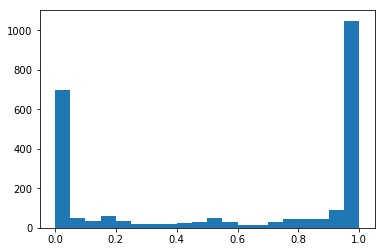

In [11]:
pipe.supervise()

In [12]:
pipe.classify(config)

[1] Testing dim = 50, dropout = 2.50e-01, rebalance = 2.50e-01, lr = 1.00e-03


AttributeError: 'Bbox' object has no attribute 'get_word_start'